In [1]:
import limix
import pickle as pkl
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from copy import deepcopy
import os
from os.path import join
import simplejson as json
import hashlib
import pandas as pd
from tqdm import tqdm
from glob import glob
import re
from plot import plot_poisson_ordered, plot_distplots, plot_distplot
from util import get_amelie_selection
from urllib.request import urlopen
try:
    import ipfsapi
    has_ipfs = True
except ModuleNotFoundError:
    has_ipfs = False


if has_ipfs:
    try:
        ipfs = ipfsapi.connect('127.0.0.1', 5001)
    except Exception:
        has_ipfs = False

only_hash = True

# Load data (Amelie's and Hannah's)

In [2]:
if os.path.exists("data/traits-kinship-hannah-amelie.pkl"):
    data = pkl.load(open("data/traits-kinship-hannah-amelie.pkl", "rb"))
else:
    url = "http://ipfs.io/ipfs/QmXtFuoA3JTkhhpUpqh4dyu3FJLUG7DWAmXwUk1N2TMbAh"
    data = pkl.load(urlopen(url))
    
dst_folder = "2"
if not os.path.exists(dst_folder):
    os.mkdir(dst_folder)
if not os.path.exists(join(dst_folder, 'phenotype')):
    os.mkdir(join(dst_folder, 'phenotype'))
if not os.path.exists(join(dst_folder, 'kinship')):
    os.mkdir(join(dst_folder, 'kinship'))

In [3]:
# imputed phenotypes after amelie+hannah's preprocessing
data['ipheno'].head()

,BW_at_IPGTT,age,batch,Haemalysis,is.albino,sex,test_worked,BW_at_day9_pi,BW_at_day28_pi,Distance25_30,...,heart_weight,AUC_G,DeltaG,G0,G120,G30,G60,Latency1_40,PosturesClosedToOpen,PltClumps
Outbred1000,415.0,14.0,5.0,1.0,2.0,2.0,1.0,159.0,193.0,2147.0,...,1.0740,727.5,0.7625,5.3,5.4,7.2,6.0,11.24,9.0,49.0
Outbred1001,465.0,14.0,5.0,1.0,2.0,2.0,1.0,171.0,195.0,2359.0,...,1.0217,694.5,1.0875,4.7,4.7,7.7,5.6,13.97,6.0,44.0
Outbred1002,415.0,14.0,5.0,1.0,2.0,2.0,1.0,160.0,180.0,896.0,...,0.9952,811.5,1.3625,5.4,6.8,8.7,5.9,12.42,5.0,44.0
Outbred1003,376.0,14.0,5.0,1.0,2.0,2.0,1.0,155.0,181.0,910.0,...,0.9653,726.0,0.6500,5.4,5.0,8.1,5.6,11.25,4.0,55.0
Outbred1006,257.0,17.0,5.0,1.0,1.0,2.0,2.0,96.0,119.0,727.0,...,0.9420,802.5,0.8875,5.8,6.9,7.2,6.5,11.23,6.0,110.0


In [4]:
data['kinship'].head()

,Outbred10,Outbred100,Outbred1000,Outbred1001,Outbred1002,Outbred1003,Outbred1006,Outbred1007,Outbred1008,Outbred1009,...,Outbred987,Outbred988,Outbred989,Outbred990,Outbred991,Outbred992,Outbred993,Outbred994,Outbred995,Outbred999
Outbred10,6.009824,4.657918,5.479625,5.418838,5.404296,5.439283,5.226009,5.008503,4.948340,4.981719,...,4.980516,4.963946,4.894734,4.914590,4.949563,4.680058,4.830228,4.834785,4.789685,5.383430
Outbred100,4.657918,5.737956,4.764362,4.701020,4.709254,4.748388,4.813588,4.911552,4.841216,4.883429,...,4.865227,4.862593,4.794374,4.816218,4.885404,4.630496,4.834140,4.868218,4.862943,4.754280
Outbred1000,5.479625,4.764362,6.200240,5.806138,5.747500,5.778229,5.349606,5.087776,5.012144,5.071292,...,5.021771,5.056555,4.964942,4.964675,5.057984,4.802489,4.999009,5.008811,4.949830,5.867601
Outbred1001,5.418838,4.701020,5.806138,6.125864,5.861705,5.813432,5.328939,5.073914,4.984344,5.050553,...,4.973953,4.967413,4.921145,4.901156,4.981035,4.752995,4.962390,4.960466,4.915544,5.767700
Outbred1002,5.404296,4.709254,5.747500,5.861705,6.186393,5.757447,5.352778,5.080052,5.012185,5.100002,...,4.944851,4.981080,4.901690,4.904372,4.987777,4.702598,4.895629,4.898984,4.862922,5.820061


In [5]:
def analysis1(ipheno, kinship, pheno_name, lik, pheno_norm):
    common_samples = set(kinship.index.values).intersection(set(ipheno.index.values))
    common_samples = np.asarray(list(common_samples))
    ipheno = ipheno.reindex(common_samples).copy()
    kinship = kinship.reindex(index=common_samples).copy()
    kinship = kinship.reindex(columns=common_samples).copy()
    assert(all(kinship.index.values == kinship.columns.values))
    assert(all(kinship.index.values == ipheno.index.values))
    
    y = pheno_norm(ipheno.loc[:, pheno_name])
    
    phenotype_series = pd.Series(y, ipheno.loc[:, pheno_name].index.values)
    obj = pkl.dumps(phenotype_series)
    m = hashlib.sha1()
    m.update(obj)
    phenotype_hex = m.hexdigest()
    with open(join(dst_folder, "phenotype", phenotype_hex + ".series.pkl"), "wb") as f:
        f.write(obj)
    
    obj = pkl.dumps(kinship)
    m = hashlib.sha1()
    m.update(obj)
    kinship_hex = m.hexdigest()
    with open(join(dst_folder, "kinship", kinship_hex + ".dataframe.pkl"), "wb") as f:
        f.write(obj)

    call = "limix.her.estimate(y, lik, kinship, verbose=False)"
    h2 = limix.her.estimate(phenotype_series, lik, kinship, verbose=False)
    
    return dict(h2=h2, lik=lik, call=call, phenotype=phenotype_hex, kinship=kinship_hex)

In [6]:
# for name in data['ipheno'].columns.values:
#     dst_file = join(dst_folder, "h2_ipheno_normal_" + name + "_mean_standardize.json")
#     if os.path.exists(dst_file):
#         continue
#     r = analysis1(data['ipheno'], data['kinship'], name, 'normal', limix.qc.mean_standardize)
#     json.dump(r, open(dst_file, "w"))

In [7]:
# for name in data['ipheno'].columns.values:
#     dst_file = join(dst_folder, "h2_ipheno_normal_" + name + "_quantile_gaussianize.json")
#     if os.path.exists(dst_file):
#         continue
#     r = analysis1(data['ipheno'], data['kinship'], name, 'normal', limix.qc.quantile_gaussianize)
#     json.dump(r, open(dst_file, "w"))

In [8]:
def isbernoulli(x):
    x = np.asarray(x, float)
    u = np.unique(x)
    if len(u) == 2:
        return True
    return False

def get_bernoulli(x):
    x = np.asarray(x, float)
    u = np.unique(x)
    i0 = x == u[0]
    i1 = x == u[1]
    x[i0] = 0.0
    x[i1] = 1.0
    return x

def isdiscrete(x):
    x = np.asarray(x, float)
    ok = np.isfinite(x)
    return all(x[ok] == np.asarray(x[ok], int))

def get_poisson(x):
    x = np.asarray(x, float)
    mi = min(x)    
    if mi < 0:
        x += -mi
    return x

def isnumber(x):
    try:
        np.asarray(x, float)
    except ValueError:
        return False
    return True

In [9]:
# data0 = deepcopy(data)
# remove = []
# for name in data0['ipheno'].columns.values:
#     if isbernoulli(data0['ipheno'].loc[:, name]):
#         data0['ipheno'].loc[:, name] = get_bernoulli(data0['ipheno'].loc[:, name])
#     else:
#         remove.append(name)
# for name in remove:
#     del data0['ipheno'][name]

# for name in data0['ipheno'].columns.values:
#     dst_file = join(dst_folder, "h2_ipheno_bernoulli_" + name + ".json")
#     if os.path.exists(dst_file):
#         continue
#     r = analysis1(data0['ipheno'], data0['kinship'], name, 'bernoulli', lambda x: x)
#     json.dump(r, open(dst_file, "w"))

In [10]:
def analysis2(pheno, kinship, pheno_name, lik, pheno_norm):
    common_samples = set(kinship.index.values).intersection(set(pheno.index.values))
    common_samples = np.asarray(list(common_samples))
    
    pheno = pheno.reindex(common_samples).copy()
    kinship = kinship.reindex(index=common_samples).copy()
    kinship = kinship.reindex(columns=common_samples).copy()
    
    assert(all(kinship.index.values == kinship.columns.values))
    assert(all(kinship.index.values == pheno.index.values))

    ok = np.isfinite(pheno.loc[:, pheno_name])
    common_samples = common_samples[ok]
    
    pheno = pheno.reindex(common_samples).copy()
    kinship = kinship.reindex(index=common_samples).copy()
    kinship = kinship.reindex(columns=common_samples).copy()
    
    assert(all(kinship.index.values == kinship.columns.values))
    assert(all(kinship.index.values == pheno.index.values))
    
    if not all(np.isfinite(pheno[pheno_name])):
        raise ValueError("not all finite: {}".format(pheno_name))
    
    y = pheno_norm(pheno.loc[:, pheno_name])
    
    phenotype_series = pd.Series(y, pheno.loc[:, pheno_name].index.values)
    obj = pkl.dumps(phenotype_series)
    m = hashlib.sha1()
    m.update(obj)
    phenotype_hex = m.hexdigest()
    with open(join(dst_folder, "phenotype", phenotype_hex + ".series.pkl"), "wb") as f:
        f.write(obj)
        
    obj = pkl.dumps(kinship)
    m = hashlib.sha1()
    m.update(obj)
    kinship_hex = m.hexdigest()
    with open(join(dst_folder, "kinship", kinship_hex + ".dataframe.pkl"), "wb") as f:
        f.write(obj)

    try:
        call = "limix.her.estimate(y, lik, kinship, verbose=False)"
        h2 = limix.her.estimate(y, lik, kinship, verbose=False)
    except ValueError as e:
        print(e)
        print("Pheno name: {}".format(pheno_name))
        h2 = "exception"

    return dict(h2=h2, lik=lik, call=call, phenotype=phenotype_hex, kinship=kinship_hex)

In [11]:
data['measures'].head()

,Boli_tot,Distance0_30,Distance10_15,Distance15_20,Distance20_25,Distance25,Distance25_30,Distance5,Distance5_10,Rearing0_30,...,reliable_ear_hole,scanner_ear_hole,EAE_score_at_sacrifice,sex,IPGTT_test_worked,BW_week14,BW_week17,Exp_novel_cage,Exp_zero_maze,Exp_shuttlebox
subject,,,,,,,,,,,,,,,,,,,,,
Outbred1,2.0,2670.0,195.0,61.0,230.0,1141.0,410.0,1529.0,244.0,23.0,...,True,A,0.0,M,True,311.0,348.0,Exp1,Exp10,Exp300
Outbred10,1.0,5926.0,621.0,1271.0,678.0,4572.0,756.0,1356.0,1246.0,79.0,...,True,A,0.0,M,True,315.0,334.0,Exp1,Exp10,Exp300
Outbred100,3.0,4951.0,707.0,928.0,1124.0,4164.0,523.0,789.0,882.0,38.0,...,True,A,NaN,M,True,308.0,286.0,Exp1,Exp10,Exp300
Outbred1000,0.0,14870.0,3032.0,2279.0,2231.0,12069.0,2147.0,2801.0,2380.0,85.0,...,True,B,0.0,M,True,298.0,329.0,Exp1,Exp20,Exp700
Outbred1001,5.0,12837.0,2547.0,1647.0,1073.0,9780.0,2359.0,3056.0,2155.0,86.0,...,False,B,0.0,M,True,310.0,331.0,Exp1,Exp20,Exp700


In [12]:
data0 = deepcopy(data)
remove = []
for name in data0['measures'].columns.values:
    if isnumber(data0['measures'].loc[:, name]) and isdiscrete(data0['measures'].loc[:, name]):
        data0['measures'].loc[:, name] = get_poisson(data0['measures'].loc[:, name])
    else:
        remove.append(name)
for name in remove:
    del data0['measures'][name]

for name in tqdm(data0['measures'].columns.values):
    dst_file = join(dst_folder, "h2_measures_poisson_" + name + ".json")
    if os.path.exists(dst_file):
        continue
    r = analysis2(data0['measures'], data0['kinship'], name, 'poisson', lambda x: x)
    json.dump(r, open(dst_file, "w"))

100%|██████████| 65/65 [00:00<00:00, 4042.73it/s]


In [13]:
data0 = deepcopy(data)
remove = []
for name in data0['measures'].columns.values:
    if isnumber(data0['measures'].loc[:, name]):
        data0['measures'].loc[:, name] = get_poisson(data0['measures'].loc[:, name])
    else:
        remove.append(name)
for name in remove:
    del data0['measures'][name]

for name in tqdm(data0['measures'].columns.values):
    dst_file = join(dst_folder, "h2_measures_normal_" + name + "_mean_standardize.json")
    if os.path.exists(dst_file):
        continue
    r = analysis2(data0['measures'], data0['kinship'], name, 'normal', limix.qc.mean_standardize)
    json.dump(r, open(dst_file, "w"))

100%|██████████| 204/204 [00:00<00:00, 4258.07it/s]


In [14]:
data0 = deepcopy(data)
remove = []
for name in data0['measures'].columns.values:
    if isnumber(data0['measures'].loc[:, name]):
        data0['measures'].loc[:, name] = get_poisson(data0['measures'].loc[:, name])
    else:
        remove.append(name)
for name in remove:
    del data0['measures'][name]

for name in tqdm(data0['measures'].columns.values):
    dst_file = join(dst_folder, "h2_measures_normal_" + name + "_quantile_gaussianize.json")
    if os.path.exists(dst_file):
        continue
    r = analysis2(data0['measures'], data0['kinship'], name, 'normal', limix.qc.quantile_gaussianize)
    json.dump(r, open(dst_file, "w"))

100%|██████████| 204/204 [00:00<00:00, 4324.51it/s]


# Plots

In [15]:
# patts = ["h2_ipheno_normal_(.*)_mean_standardize.json",
#          "h2_ipheno_normal_(.*)_quantile_gaussianize.json",
#          "h2_measures_poisson_(.*).json",
#          "h2_measures_normal_(.*)_mean_standardize.json",
#          "h2_measures_normal_(.*)_quantile_gaussianize.json"]

patts = ["h2_measures_poisson_(.*).json",
         "h2_measures_normal_(.*)_mean_standardize.json",
         "h2_measures_normal_(.*)_quantile_gaussianize.json"]

data = {patt:{} for patt in patts}
for path in glob(join(dst_folder, "*.json")):
    filename = path.split("/")[1]
    for patt in patts:
        match = re.match(patt, filename)
        if match:
            trait_name = match.groups(0)[0]
            data[patt][trait_name] = json.load(open(path, "r"))
            break

patt2name = {'h2_measures_poisson_(.*).json':'MPoisson',
             'h2_measures_normal_(.*)_mean_standardize.json':'MNormalStd',
             'h2_measures_normal_(.*)_quantile_gaussianize.json':'MNormalGau'}

rows = []
for patt in patts:
    for trait_name, d0 in tqdm(data[patt].items()):
        
#         y = pd.read_pickle(open(join(dst_folder, 'phenotype', d0['phenotype'] + ".series.pkl"), "rb"))
#         fig = plt.figure()
#         ax = fig.subplots()
#         plot_distplot(y, ax)
#         plt.text(0.5, 0.5, patt2name[patt], horizontalalignment='center',
#                  verticalalignment='center', transform=ax.transAxes)
#         plt.savefig(join(dst_folder, 'tmp', 'distplot.png'), format='png')
#         plt.close()
        if has_ipfs:
            res = ipfs.add(join(dst_folder, 'tmp', 'distplot.png'), only_hash=only_hash)
            ipfs_addr = "/ipfs/" + res['Hash']
        else:
            ipfs_addr = 'Unknown'

        rows.append([trait_name, patt2name[patt], d0['h2'], ipfs_addr])
rows = sorted(rows, key=lambda x: x[0])

df = pd.DataFrame(data=rows, columns=["trait", "model", "h2", "trait-distplot"])
df.loc[df['h2'] == 'exception', 'h2'] = np.nan
df = df.dropna()

100%|██████████| 204/204 [00:00<00:00, 560706.43it/s]


In [16]:
traits = list(df.query("model == 'MPoisson'")["trait"])
# patt_traits = {}
# for k, v in data.items():
#     patt_traits[k] = []
#     for k0, v0 in v.items():
#         patt_traits[k].append(k0)
#     patt_traits[k] = set(patt_traits[k]) 

# for i, k in enumerate(patt_traits.keys()):
#     if i == 0:
#         traits = patt_traits[k]
#     else:
#         traits = traits.intersection(patt_traits[k])

In [17]:
# def make_clickable(val):
#     v = val['trait-distplot']
#     val['trait-distplot'] = '<a target="_blank" href="https://ipfs.io{}">https://ipfs.io{}</a>'.format(v, v)
#     return val

In [18]:
amelie_selection = get_amelie_selection()

In [19]:
traits_slides= ["Avoidances1_40", "Avoidances6_10", "Avoidances21_30", "Avoidances31_40", "Rearing10_15", "time_freezing"]

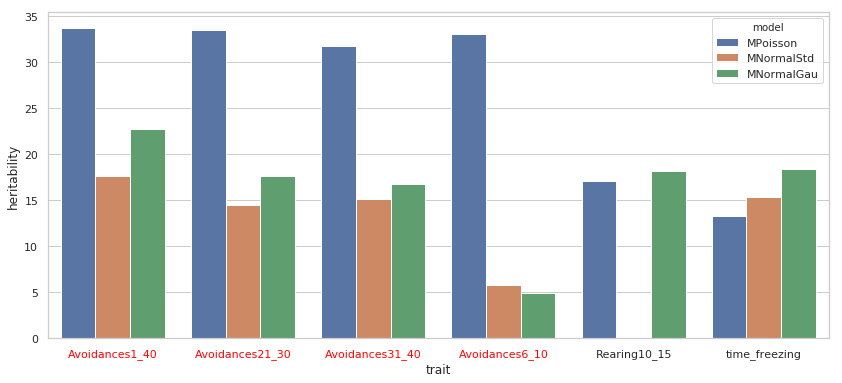

In [26]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(14, 6))
ax = fig.subplots()
df0 = df.copy()
df0["heritability"] = df0["h2"] * 100
sns.barplot(y="heritability", x="trait", hue="model",
            data=df0[df0['trait'].isin(traits_slides)],
            ax=ax)

ticklabels = ax.xaxis.get_ticklabels()
for tl in ticklabels:
    if tl.get_text() in amelie_selection:
        tl.set_color('red')

# plt.show()
plt.savefig("h2_slides.png", bbox_inches='tight')

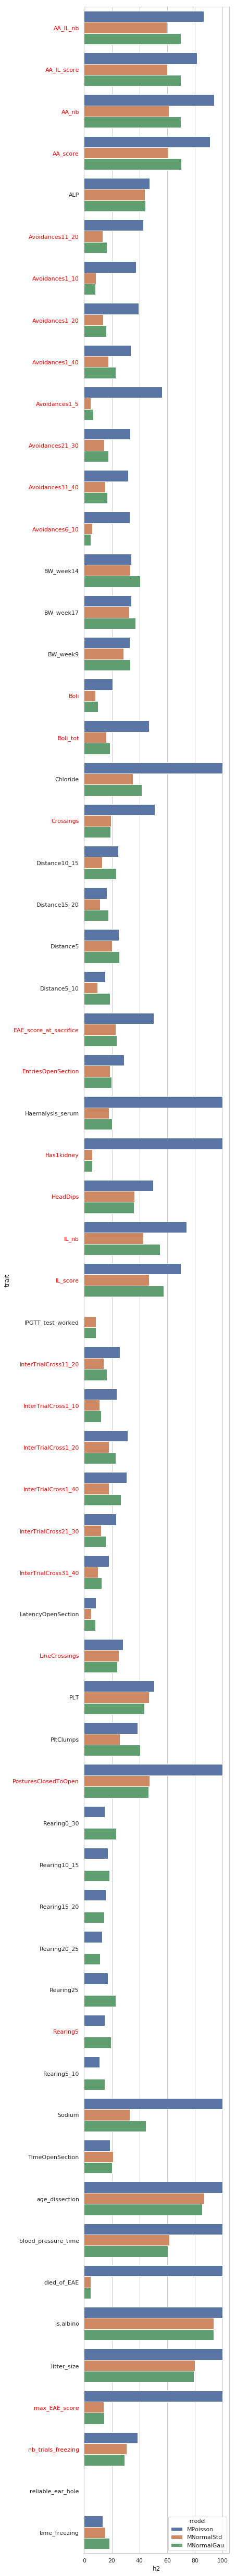

In [28]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(5, 90))
ax = fig.subplots()
df0 = df.copy()
df0["heritability"] = df0["h2"] * 100
sns.barplot(x="h2", y="trait", hue="model", data=df0[df0['trait'].isin(traits)], ax=ax)

ticklabels = ax.yaxis.get_ticklabels()
for tl in ticklabels:
    if tl.get_text() in amelie_selection:
        tl.set_color('red')

plt.show()